In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, ComplementNB, CategoricalNB
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('../data/processed/processed_train.csv')
test_df = pd.read_csv('../data/processed/processed_test.csv')

general_df = pd.concat([train_df, test_df], ignore_index=True)
general_df.columns

Index(['Unnamed: 0', 'review', 'sentiment', 'number_of_chars',
       'percentage_of_signs', 'number_of_excl_marks',
       'number_of_question_marks', 'number_of_ellipses',
       'number_of_uppercase_words', 'cleaned_review', 'tokenized_review',
       'lemmatized_review', 'stemmed_review'],
      dtype='object')

In [3]:
len(general_df), len(train_df), len(test_df)

(45999, 36770, 9229)

In [4]:
def vectorize_review(
        df: pd.DataFrame,
        processed_text_col_name: str,
        train_df_len: int,
        vectorizer
):
    vectorized_data = vectorizer.fit_transform(df[processed_text_col_name])
    return train_test_split(
        vectorized_data,
        df['sentiment'],
        test_size=train_df_len,
        shuffle=False
    )


def train_model(
        X_train,
        Y_train,
        classifier
):
    classifier.fit(X_train, Y_train)
    joblib.dump(classifier, f'../outputs/models/{classifier.__class__.__name__}.pkl')
    return classifier


def test_model(
    X_test,
    Y_test,
    classifier
):
    predicted = classifier.predict(X_test)
    accuracy_score = metrics.accuracy_score(predicted, Y_test)
    cf_matrix = metrics.confusion_matrix(Y_test, predicted)
    classification_report = metrics.classification_report(Y_test, predicted)

    models_evaluation_metrics = ""
    models_evaluation_metrics += f'ComplementNB model accuracy is {round(accuracy_score * 100, 2)}%'
    models_evaluation_metrics += '\n------------------------------------------------\n'
    models_evaluation_metrics += 'Confusion Matrix:\n'
    models_evaluation_metrics += str(pd.DataFrame(cf_matrix))
    models_evaluation_metrics += '\n------------------------------------------------\n'
    models_evaluation_metrics += 'Classification Report:\n'
    models_evaluation_metrics += str(classification_report)

    print(models_evaluation_metrics)

    with open(f"../outputs/predictions/{classifier.__class__.__name__}_metrics.txt", 'w') as f:
        f.write(models_evaluation_metrics)

    predicted_df = test_df
    predicted_df['predicted_sentiment'] = pd.Series(predicted)
    predicted_df.to_csv(f"../outputs/predictions/{classifier.__class__.__name__}_predictions.csv")

    return accuracy_score, cf_matrix, classification_report

# Vectorization.

We have prepared two versions of vectorized text: using Count and TF-IDF vectorizer.

In [5]:
count_vectorizer = CountVectorizer()
count_X_train, count_X_test, count_y_train, count_y_test = vectorize_review(
    df=general_df,
    processed_text_col_name='stemmed_review',
    train_df_len=len(train_df),
    vectorizer=count_vectorizer
)

tfidf_vectorizer = TfidfVectorizer()
tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = vectorize_review(
    df=general_df,
    processed_text_col_name='stemmed_review',
    train_df_len=len(train_df),
    vectorizer=tfidf_vectorizer
)

# Models training.

## Bernoulli Naive Bayes.

Bernoulli Naive Bayes is a variant of Naive Bayes that is particularly suited for binary/boolean features. The model is based on the Bayes Theorem and assumes that all features are independent given the class. In text classification, this model is typically used with binary feature vectors (rather than counts or TF-IDF features) which indicate the presence or absence of a word. For sentiment analysis, each word in the vocabulary is treated as a feature and it contributes independently to the probability that the sentiment is positive or negative.

*Advantages*:
- **Handling of Binary Data**: It works well with binary feature models which are common in text processing where presence or absence of words is a useful feature.
- **Scalability and Speed**: The independence assumption simplifies computation, making this model very efficient and scalable to large datasets.
- **Performance**: Despite its simplicity and the strong independence assumption, Bernoulli Naive Bayes can perform surprisingly well on sentiment analysis tasks, especially when the dataset is large.

In [6]:
BNB = BernoulliNB()
bernoulli_nb = train_model(
    tfidf_X_train, 
    tfidf_y_train, 
    BNB
)

bernoulli_res = test_model(
    tfidf_X_test,
    tfidf_y_test,
    bernoulli_nb
)

ComplementNB model accuracy is 85.13%
------------------------------------------------
Confusion Matrix:
       0      1
0  16040   2402
1   3065  15263
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.87      0.85     18442
    positive       0.86      0.83      0.85     18328

    accuracy                           0.85     36770
   macro avg       0.85      0.85      0.85     36770
weighted avg       0.85      0.85      0.85     36770



In [7]:
BNB = BernoulliNB()
bernoulli_nb = train_model(
    count_X_train, 
    count_y_train, 
    BNB
)

test_model(
    count_X_test,
    count_y_test,
    bernoulli_nb
)

ComplementNB model accuracy is 85.13%
------------------------------------------------
Confusion Matrix:
       0      1
0  16040   2402
1   3065  15263
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.87      0.85     18442
    positive       0.86      0.83      0.85     18328

    accuracy                           0.85     36770
   macro avg       0.85      0.85      0.85     36770
weighted avg       0.85      0.85      0.85     36770



(0.851319010062551,
 array([[16040,  2402],
        [ 3065, 15263]], dtype=int64),
 '              precision    recall  f1-score   support\n\n    negative       0.84      0.87      0.85     18442\n    positive       0.86      0.83      0.85     18328\n\n    accuracy                           0.85     36770\n   macro avg       0.85      0.85      0.85     36770\nweighted avg       0.85      0.85      0.85     36770\n')

## SVM.

Support Vector Machine (SVM) is a powerful and versatile supervised machine learning algorithm used for classification and regression tasks. In the context of text sentiment analysis, SVM with a linear kernel is particularly useful. The linear kernel is a dot product between two instances, and it offers a straightforward linear decision boundary. The main idea behind SVM is to find the optimal hyperplane that maximally separates the classes in the feature space. For binary classification, such as positive/negative sentiment analysis, SVM focuses on constructing the hyperplane that has the largest distance to the nearest training data points of any class, which are called support vectors. This margin maximization offers robustness, especially in high-dimensional spaces.

*Advantages*:

- **Effectiveness in High-Dimensional Spaces**: SVMs are particularly effective in high-dimensional spaces, which is typical in text data due to the large vocabulary size.
- **Robustness**: The margin maximization principle helps SVMs to be robust against overfitting, especially in linearly separable cases.
- **Scalability**: With linear kernels, SVMs can scale relatively well to large text datasets.

In [8]:
scaler = StandardScaler(with_mean=False)

scaler.fit(count_X_train)

norm_count_X_train = scaler.transform(count_X_train)
norm_count_X_test = scaler.transform(count_X_test)
norm_count_y_train = count_y_train.apply(lambda x: 1 if x == 'positive' else 0)
norm_count_y_test = count_y_test.apply(lambda x: 1 if x == 'positive' else 0)

SVM = svm.SVC(kernel='linear')
SVM = train_model(
    norm_count_X_train,
    norm_count_y_train,
    SVM
)

svm_results = test_model(
    norm_count_X_test,
    norm_count_y_test,
    SVM
)

ComplementNB model accuracy is 81.95%
------------------------------------------------
Confusion Matrix:
       0      1
0  14943   3499
1   3139  15189
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     18442
           1       0.81      0.83      0.82     18328

    accuracy                           0.82     36770
   macro avg       0.82      0.82      0.82     36770
weighted avg       0.82      0.82      0.82     36770



## Logistic Regression.

Logistic Regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable. In the context of sentiment analysis, the probabilities describing the possible outcomes of a single trial are modeled as a function of the predictor variables (text features). Logistic regression measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic function, which is an S-shaped curve that can take any real-valued number and map it into a value between 0 and 1, but never exactly at those limits.

*Advantages*:

- **Interpretability**: Unlike more complex models, logistic regression models have the advantage of being interpretable. Each feature’s weights indicate the importance and influence on the sentiment classification.
- **Efficiency**: Logistic regression is less computationally intensive than more complex algorithms, making it a relatively fast model to train.
- **Probabilistic** Interpretation: The model outputs a probability for the sentiment class, which can be a useful measure of confidence in the classification.

In [9]:
LG = LogisticRegression()
logistic_regression = train_model(
    tfidf_X_train,
    tfidf_y_train,
    LG
)

lg_res = test_model(
    tfidf_X_test,
    tfidf_y_test,
    logistic_regression
)

ComplementNB model accuracy is 86.99%
------------------------------------------------
Confusion Matrix:
       0      1
0  15806   2636
1   2149  16179
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.86      0.87     18442
    positive       0.86      0.88      0.87     18328

    accuracy                           0.87     36770
   macro avg       0.87      0.87      0.87     36770
weighted avg       0.87      0.87      0.87     36770



In [10]:
LG = LogisticRegression()
logistic_regression = train_model(
    count_X_train,
    count_y_train,
    LG
)

lg_res = test_model(
    count_X_test,
    count_y_test,
    logistic_regression
)

ComplementNB model accuracy is 85.69%
------------------------------------------------
Confusion Matrix:
       0      1
0  15694   2748
1   2513  15815
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.85      0.86     18442
    positive       0.85      0.86      0.86     18328

    accuracy                           0.86     36770
   macro avg       0.86      0.86      0.86     36770
weighted avg       0.86      0.86      0.86     36770



# Models Evaluation.

## Confusion matrices.

Text(0.5, 1.0, 'Confusion matrix of linear SVM with test data with accuracy 81.95%')

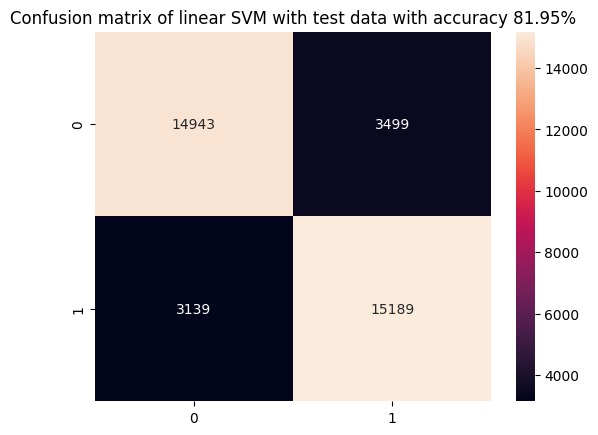

In [11]:
sns.heatmap(svm_results[1], annot=True, fmt='d') \
    .set_title(f'Confusion matrix of linear SVM with test data with accuracy {round(svm_results[0] * 100, 2)}%')

Text(0.5, 1.0, 'Confusion matrix of Bernoulli Naive Bayes with test data  with accuracy 85.13%')

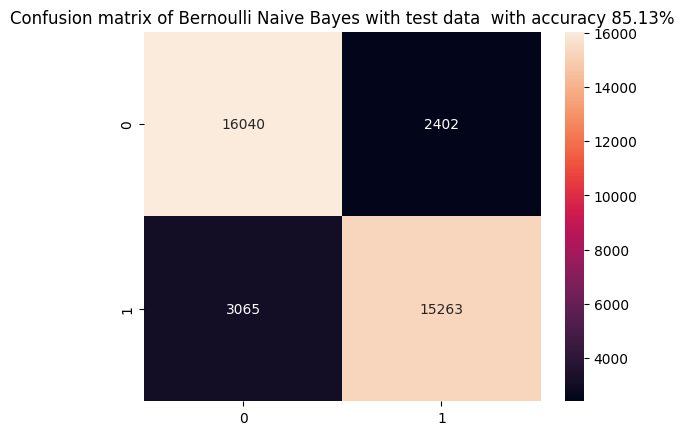

In [12]:
sns.heatmap(bernoulli_res[1], annot=True, fmt='d') \
            .set_title(f'Confusion matrix of Bernoulli Naive Bayes with test data  with accuracy {round(bernoulli_res[0] * 100, 2)}%')

Text(0.5, 1.0, 'Confusion matrix of Logistic Regression with test data with accuracy 85.69%')

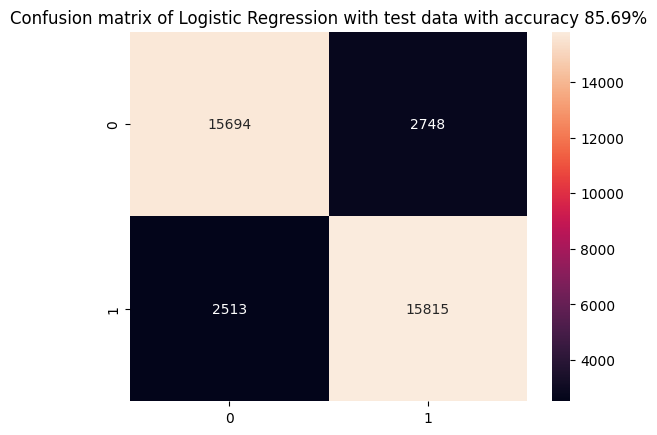

In [13]:
sns.heatmap(lg_res[1], annot=True, fmt='d') \
   .set_title(f'Confusion matrix of Logistic Regression with test data with accuracy {round(lg_res[0] * 100, 2)}%')